# DGE using MAST

This notebook performs MAST DGE using `run_MAST.R` script.

**Dataset**: MIS-C dataset

**Type of cells**: HSPC

**DGE condition**: Different timepoints of disease status

**Inputs**: Filtered anndata object with HSPC cells only, `run_MAST.R` script

**Output 1**: Seurat objects and jobs submitted to run MAST

**Output 2 (After sucesfully finishing running jobs)**: Volcano plots and marker genes

In [1]:
import rpy2
import anndata2ri
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from rpy2.robjects import pandas2ri, r, globalenv
from rpy2.robjects.packages import importr
from adjustText import adjust_text
import subprocess

In [2]:
anndata2ri.activate()
%load_ext rpy2.ipython

/scratch/lsftmp/8531279.tmpdir/ipykernel_112330/2547887543.py:1: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
anndata2ri.deactivate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
library(parallel)
library(MAST)
library(data.table)
set.seed(42)
options(mc.cores = detectCores() - 5)

In [5]:
input_dir = '/data/niecr/ramaiar/misc/results_seurat/anndata_obj'

In [6]:
output_dir = '/data/niecr/ramaiar/misc/results_seurat/DGE/MAST' # Save MAST results

In [19]:
intermediate_path = '/data/niecr/ramaiar/misc/results_seurat/DGE/intermediate' # Save seurat objects

In [33]:
run_MAST_script = '/data/niecr/ramaiar/misc/qc_analysis/DGE/run_MAST.R' # Path to script

# 1. Load Data

In [14]:
rna_ad_path = os.path.join(input_dir, 'hspc_UNK_removed.h5ad')
rna_ad = sc.read_h5ad(rna_ad_path)
rna_ad

AnnData object with n_obs × n_vars = 19092 × 27424
    obs: 'og_barcode', 'batch_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct', 'doublet', 'doublet_score', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'orig.barcode', 'RNA_snn_res.2', 'seurat_clusters', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pANN_0.25_0.09_2745', 'DF.classifications_0.25_0.09_2745', 'DF.classifications_0.25_0.09_2627', 'pANN_0.25_0.09_623', 'DF.classifications_0.25_0.09_623', 'DF.classifications_0.25_0.09_808', 'pANN_0.25_0.09_701', 'DF.classifications_0.25_0.09_701', 'pANN_0.25_0.09_1124', 'DF.classifications_0.25_0.09_1124', 'pANN_0.25_0.09_1500', 'DF.classifications_0.25_0.09_1500', 'pANN_0.25_0.09_1478', 'DF.classifications_0.25_0.09_1478', '

Check if the count matrix and log normalized matrix are correctly assigned

In [15]:
rna_ad.X[0:10,10:20].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.3579658 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.53401184, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.43999663, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [16]:
rna_ad.layers['raw_counts'][0:10,10:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# 2. Functions to prep data for MAST

In [17]:
def prep_for_mast(adata,cells1, cells2, df1_path, df2_path):
    
    # make new ad with just cells and log mtx
    all_cells = cells1 + cells2
    sub_obs = adata[all_cells,].obs.copy()
    sub_obs['group'] = np.where(sub_obs.index.isin(cells1), 1, 2)
    sce_v2 = sc.AnnData(X = adata[all_cells, :].X, 
                 obs = pd.DataFrame({'group': sub_obs['group'].astype('int')}, 
                                    index = sub_obs.index),
                 var = pd.DataFrame(index = adata.var.index))
    print(sce_v2)
    # make sc experiment in R
    %R -i sce_v2 counts(sce_v2) <- assay(sce_v2, "X")
    
    # identify cells belonging to each group
    %R id_cells1 <- which(colData(sce_v2)$group == 1)
    %R id_cells2 <- which(colData(sce_v2)$group == 2)

    # Create two dataframes: 
    %R df1 <- t(data.frame(as.matrix(counts(sce_v2)[, id_cells1]))) # transpose because in sce genes are rows
    %R df2 <- t(data.frame(as.matrix(counts(sce_v2)[, id_cells2]))) # transpose because in sce genes are rows
    
    # write to file as rds
    %R -i df1_path saveRDS(df1,df1_path)
    %R -i df2_path saveRDS(df2,df2_path)

In [31]:
# Function to submit lsf jobs to run MAST
def submit_job_MAST(file1,file2,run_MAST_script,output_dir,out_filename,conda_env='multiome_winner_test3'):
    
    script_content = f"""#!/bin/bash
bsub -J "{out_filename}" \\
    -o "{output_dir}/%J.out" \\
    -e "{output_dir}/%J.err" \\
    -q gpuqueue \\
    -n 2 \\
    -R rusage[mem=100] \\
    -W 10:00 \\
    "source ~/.bashrc; conda run -n {conda_env} Rscript {run_MAST_script} {file1} {file2} {output_dir}/{out_filename}"
"""
    
    # Write the script to a file
    script_filename = 'run_job.sh'
    with open(script_filename, 'w') as file:
        file.write(script_content)
    subprocess.run(['chmod', '+x', script_filename])

    # Execute the script
    try:
        result = subprocess.run(['bash', script_filename], check=True, capture_output=True, text=True)
        print(f'Submitted job for {out_filename}')
    except subprocess.CalledProcessError as e:
        print(f'Error submitting job: {e}')
        print(f'Stderr: {e.stderr}')
    finally:
        if os.path.exists(script_filename):
            os.remove(script_filename)

# 3. Prepare comparison groups in all celltypes

In [21]:
condition = 'Disease.Status3'

In [22]:
rna_ad.obs[condition].dropna().unique().tolist()

['Baseline_MIS-C',
 'D28_MIS-C',
 'MISC-recovered',
 'M6_POSSIBLE MIS-C',
 'nan',
 'Baseline_POSSIBLE MIS-C',
 'D28_POSSIBLE MIS-C',
 'Healthy_Healthy',
 'D28_COVID',
 'Baseline_COVID',
 'M6_COVID',
 'M12_COVID',
 'M12_POSSIBLE MIS-C']

In [23]:
# dictionary of interested groups
DGE_comparison = { 1: {'reference': 'MISC-recovered', 'group': 'Baseline_MIS-C'},
                 2: {'reference': 'MISC-recovered', 'group': 'D28_MIS-C'},
                 3: {'reference': 'MISC-recovered', 'group': 'Baseline_COVID'},
                 4: {'reference': 'MISC-recovered', 'group': 'D28_COVID'},
                 5: {'reference': 'MISC-recovered', 'group': 'M6_COVID'},
                 6: {'reference': 'MISC-recovered', 'group': 'M12_COVID'}}

# 4. Run MAST

In [32]:
for groups in DGE_comparison.keys():
    reference = DGE_comparison[groups]['reference']
    group = DGE_comparison[groups]['group']
    print(f'Running {reference} VS {group}')
    
    # get cells
    #sub_ad = rna_ad[rna_ad.obs[celltype_obs_col] == celltype,]
    cells1 = list(rna_ad[rna_ad.obs[condition] == group,].obs_names)
    cells2 = list(rna_ad[rna_ad.obs[condition] == reference,].obs_names)
    
    # output path
    df1_path = intermediate_path + group +'_df.rds'
    df2_path = intermediate_path + reference + '_df.rds'
    print(len(cells1),len(cells2))
    out_filename = f'{reference}_VS_{group}_MAST_RES.csv'
     
    # run MAST
    prep_for_mast(rna_ad, cells1, cells2, df1_path, df2_path)
    submit_job_MAST(df1_path,df2_path,run_MAST_script,output_dir,out_filename) # Reference must be the 2nd file

Running MISC-recovered VS Baseline_MIS-C
2799 3006
AnnData object with n_obs × n_vars = 5805 × 27424
    obs: 'group'
Submitted job for MISC-recovered_VS_Baseline_MIS-C_MAST_RES.csv
Running MISC-recovered VS D28_MIS-C
2799 6933
AnnData object with n_obs × n_vars = 9732 × 27424
    obs: 'group'
Submitted job for MISC-recovered_VS_D28_MIS-C_MAST_RES.csv
Running MISC-recovered VS Baseline_COVID
2799 114
AnnData object with n_obs × n_vars = 2913 × 27424
    obs: 'group'
Submitted job for MISC-recovered_VS_Baseline_COVID_MAST_RES.csv
Running MISC-recovered VS D28_COVID
2799 2212
AnnData object with n_obs × n_vars = 5011 × 27424
    obs: 'group'
Submitted job for MISC-recovered_VS_D28_COVID_MAST_RES.csv
Running MISC-recovered VS M6_COVID
2799 6
AnnData object with n_obs × n_vars = 2805 × 27424
    obs: 'group'
Submitted job for MISC-recovered_VS_M6_COVID_MAST_RES.csv
Running MISC-recovered VS M12_COVID
2799 841
AnnData object with n_obs × n_vars = 3640 × 27424
    obs: 'group'
Submitted job 

In [37]:
%%bash
# Check if the jobs are submitted
bjobs

       JOBID       USER     JOB_NAME   STAT      QUEUE  FROM_HOST    EXEC_HOST   SUBMIT_TIME    START_TIME  TIME_LEFT
     8531394   ramaiar1 *AST_RES.csv    RUN   gpuqueue       ln10       2*lt01  Aug  7 18:38  Aug  7 18:43     9:58 L
     8531345   ramaiar1 *8-06.pickle    RUN   gpuqueue lilac-ln02       2*lt03  Aug  7 18:11  Aug  7 18:38   159:53 L
     8531393   ramaiar1 *AST_RES.csv    RUN   gpuqueue       ln10       2*lt06  Aug  7 18:37  Aug  7 18:42     9:57 L
     8531343   ramaiar1 *8-07.pickle    RUN   gpuqueue lilac-ln02       2*lf02  Aug  7 18:11  Aug  7 18:32   159:47 L
     8531342   ramaiar1 *8-07.pickle    RUN   gpuqueue lilac-ln02       2*lf01  Aug  7 18:11  Aug  7 18:27   159:42 L
     8531346   ramaiar1 *8-07.pickle    RUN   gpuqueue lilac-ln02       2*lf01  Aug  7 18:11  Aug  7 18:42   159:57 L
     8531392   ramaiar1 *AST_RES.csv    RUN   gpuqueue       ln10       2*lx07  Aug  7 18:35  Aug  7 18:37     9:52 L
     8531344   ramaiar1 *8-07.pickle    RUN   gpuqueue l

# 5. Visualize MAST results 
### After the jobs are done running

In [39]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from adjustText import adjust_text

In [77]:
input_dir = '/data/niecr/ramaiar/misc/results_seurat/DGE/MAST'

## 5.1. Function to plot volcano plots

In [76]:
def plot_data(data, title, nrows, ncols, output_dir, out_name):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))

    # Flatten axes into a 1D array for easier iteration
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()

    # Iterate over each cohort and plot on respective subplot
    for i, mas_result in enumerate(data):
        df = pd.read_csv(os.path.join(input_dir,mas_result))
    
        df['-log(fdr)'] = -np.log10(df['fdr'].replace(0, np.nan))  # Handle zeros
        df = df[np.isfinite(df['-log(fdr)']) & np.isfinite(df['coef'])]
    
        df['DGE'] = np.sign(df['coef']).replace({-1.0: 'DOWN', 1.0: 'UP'})
        df['temp_score'] = df['-log(fdr)']*df['coef']
    
        # Separate into 'UP' and 'DOWN' DataFrames and select top genes
        df_up = df[df['DGE'] == 'UP'].sort_values(by='temp_score').tail(15)
        df_down = df[df['DGE'] == 'DOWN'].sort_values(by='temp_score').head(15)
        selected_genes = pd.concat([df_up, df_down])
        color_palette = {'UP': 'red', 'DOWN': 'blue', 'NO': 'black'}
    
        # Plotting on current subplot
        sns.scatterplot(x='coef', y='-log(fdr)', hue='DGE', data=df, palette=color_palette, legend=False, s=40, ax=axes[i])
    
        # Draw dotted lines
        axes[i].axvline(x=0.6, color='gray', linestyle='--')
        axes[i].axvline(x=-0.6, color='gray', linestyle='--')
        axes[i].axhline(y=-np.log10(0.05), color='gray', linestyle='--')
    
        # Annotation with gene names for top and bottom 10 genes
        texts = []
        for index, row in selected_genes.iterrows():
            texts.append(axes[i].text(row['coef'], (row['-log(fdr)']),
                                      row['primerid'], fontsize=11, ha='right', va='bottom'))
    
        # Adjust text positions to avoid overlap for current subplot
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
        # Customize plot
        axes[i].set_title(f'                     {title[i][0]}', color='blue', loc='left',fontsize=12)
        axes[i].set_title('VS', color='black', loc='center',fontsize=12)
        axes[i].set_title(f'{title[i][1]}                 ', color='red', loc='right',fontsize=12)
        axes[i].set_xlabel('coef')
        axes[i].set_ylabel('-log10(FDR)')
    
        # Remove grid and border
        axes[i].grid(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir,out_name))
    plt.show()

## 5.2. Volcano plots for multiple comparisons

In [41]:
data = ['MISC-recovered_VS_Baseline_MIS-C_MAST_RES.csv',
        'MISC-recovered_VS_D28_MIS-C_MAST_RES.csv',
        'MISC-recovered_VS_Baseline_COVID_MAST_RES.csv',
        'MISC-recovered_VS_D28_COVID_MAST_RES.csv',
        'MISC-recovered_VS_M6_COVID_MAST_RES.csv',
        'MISC-recovered_VS_M12_COVID_MAST_RES.csv']

In [72]:
title = [['MISC-recovered', 'Baseline_MIS-C'],
         ['MISC-recovered','D28_MIS-C'],
         ['MISC-recovered','Baseline_COVID'],
         ['MISC-recovered','D28_COVID'],
         ['MISC-recovered','M6_COVID'],
         ['MISC-recovered','M12_COVID']]

In [73]:
nrows = 2
ncols = 3

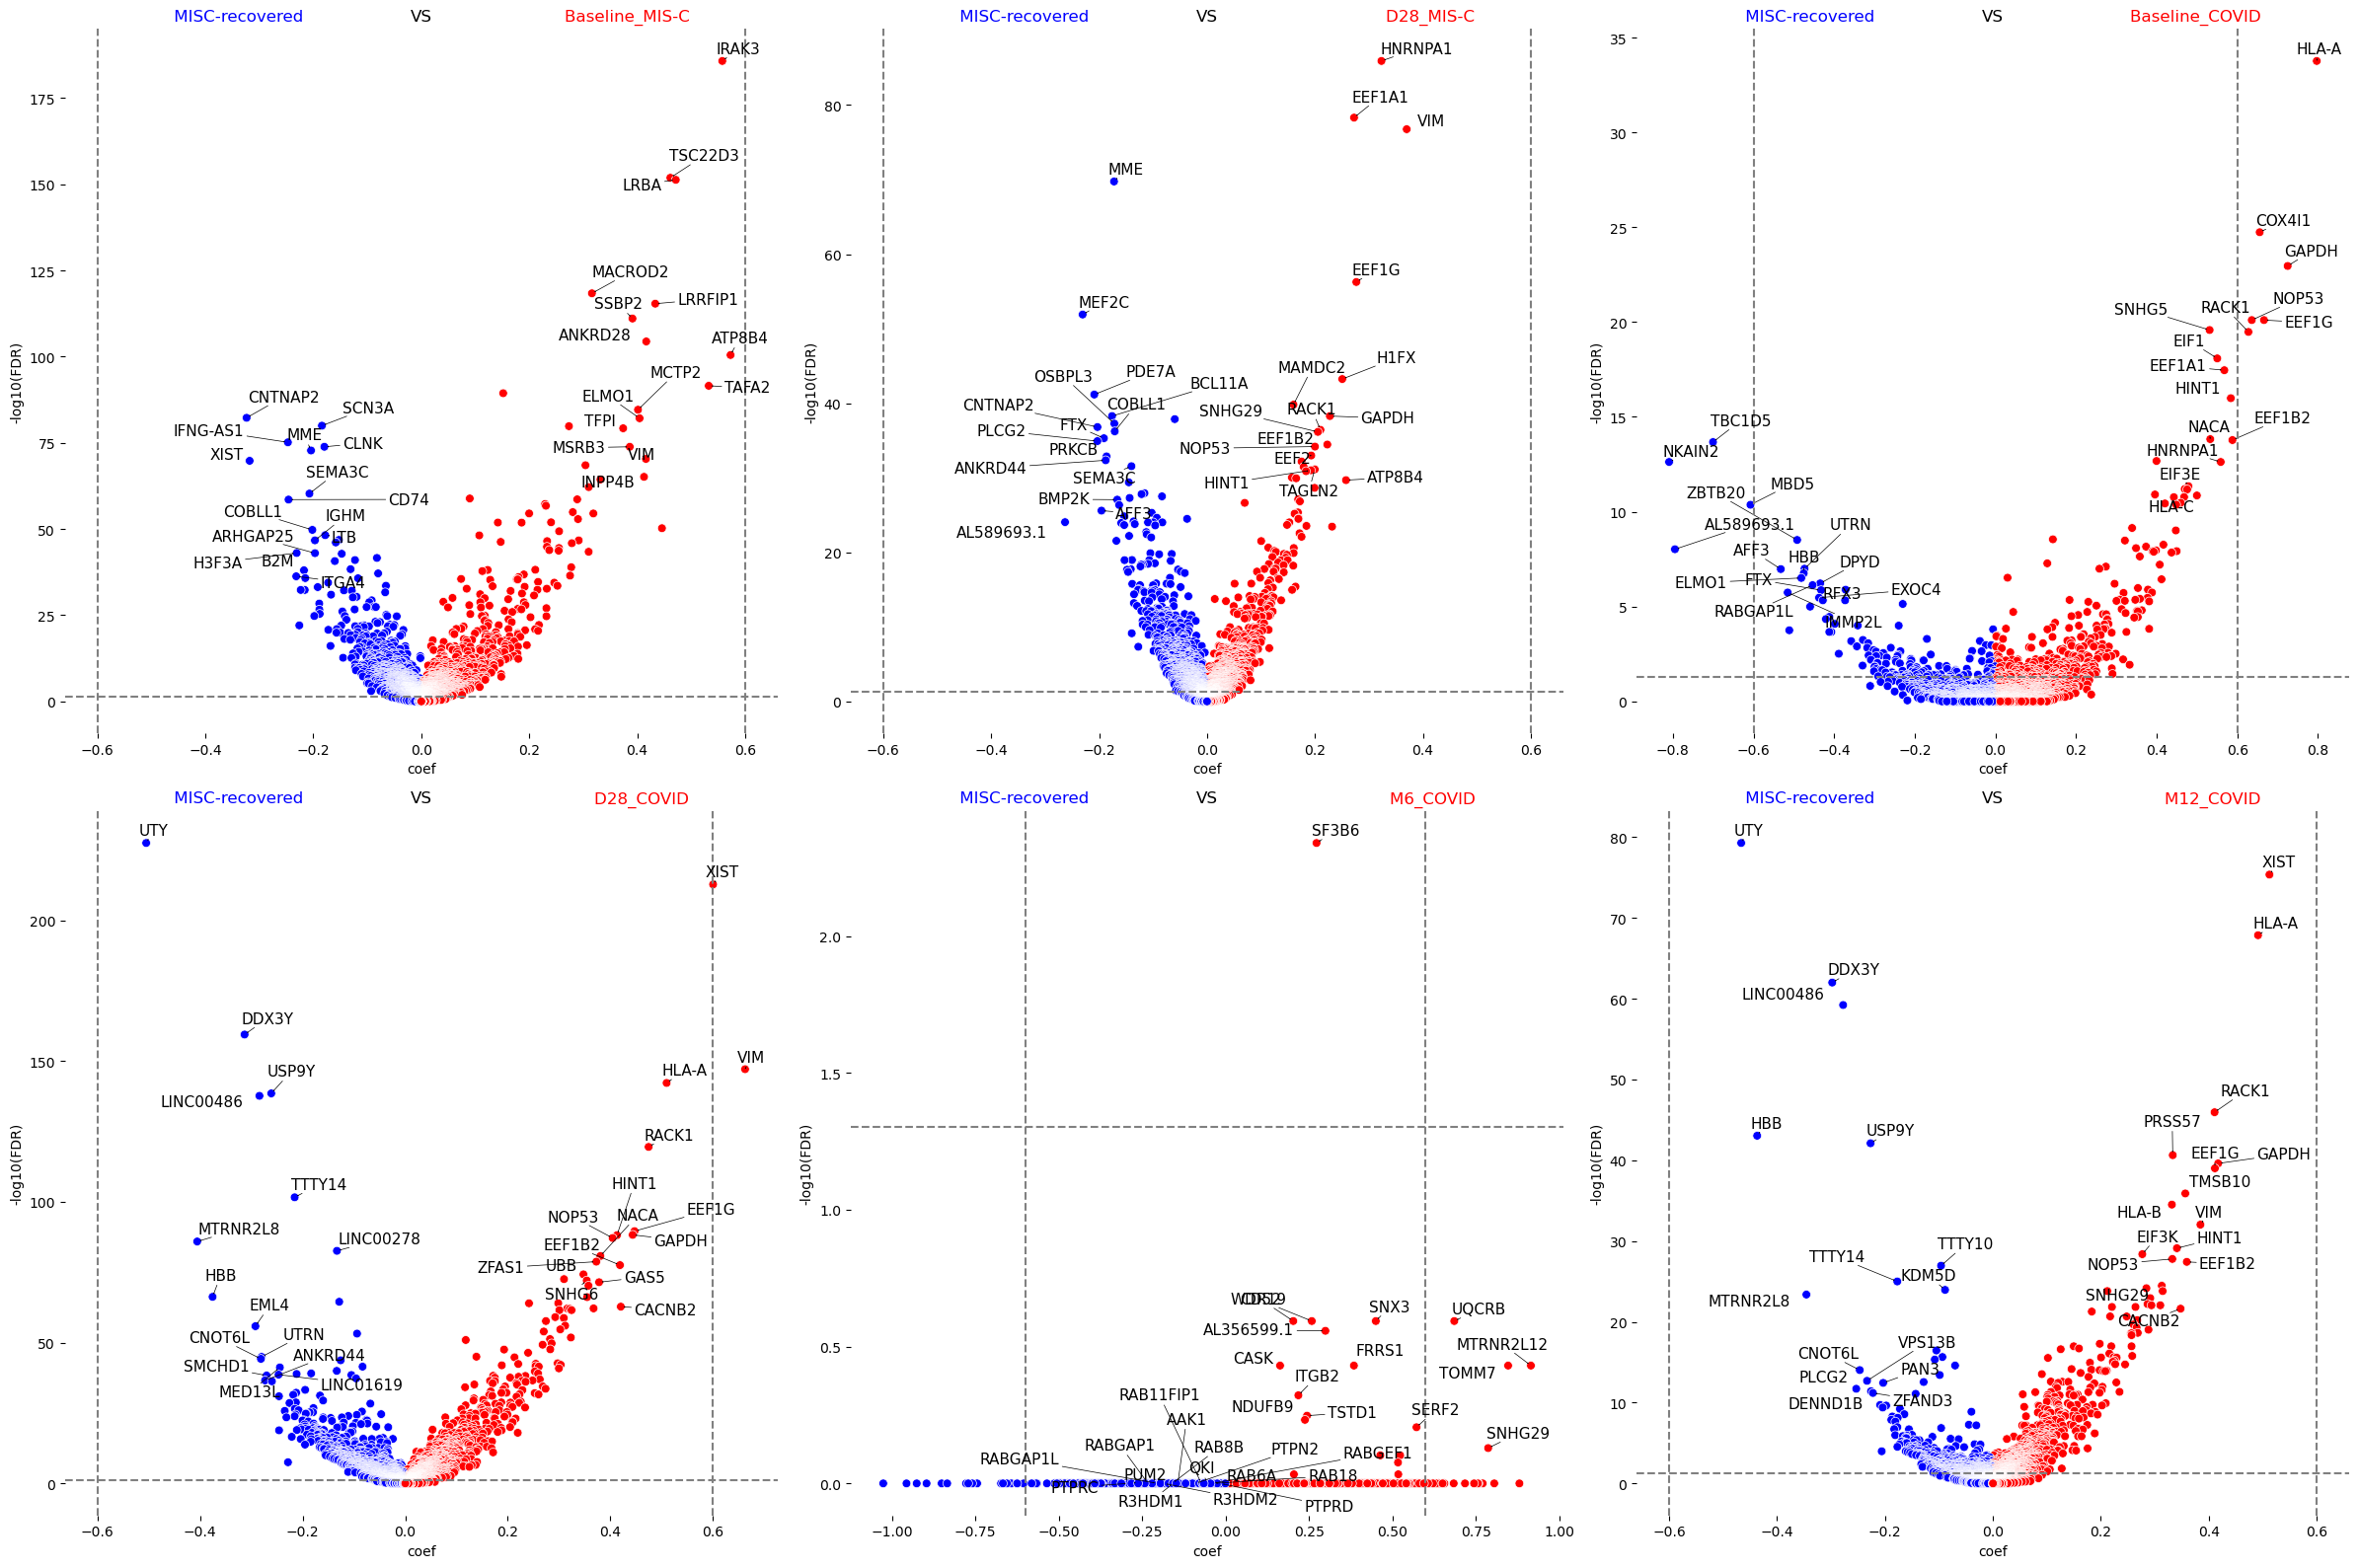

In [74]:
plot_data(data, title, nrows, ncols, output_dir, out_name='HSPC_MISC-recovered_VS_all_MAST_plots.png')

## 5.3. Volcano plots for individual comparisons

In [80]:
nrows = 1
ncols = 1
data = ['MISC-recovered_VS_Baseline_MIS-C_MAST_RES.csv']
title = [['MISC-recovered', 'Baseline_MIS-C']]

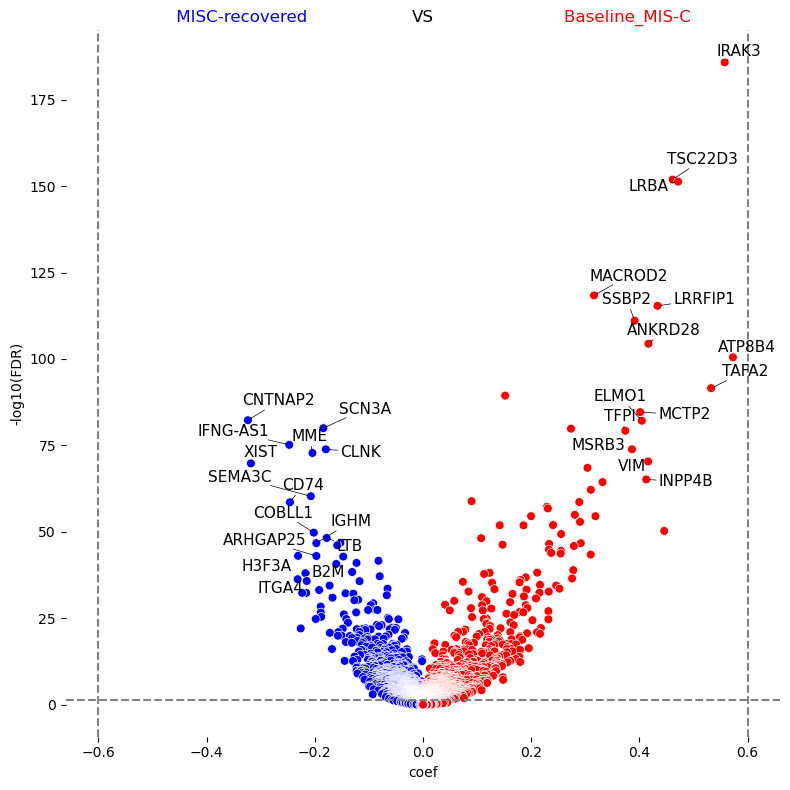

In [81]:
plot_data(data, title, nrows, ncols, output_dir, out_name='HSPC_Baseline_MIS-C_VS_Recovered_MAST_plots.png')

/home/ramaiar1/miniconda3/envs/multiome_winner_test3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


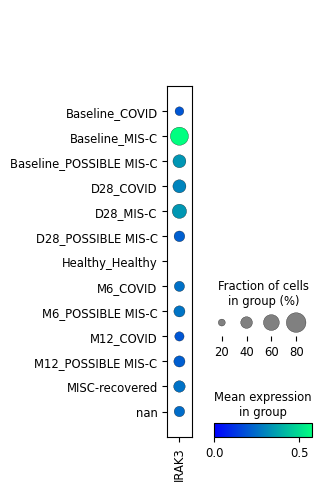

In [100]:
# Cross check if reference is alloted correctly. If it's wrong, invert the sign of df['coef'] by multiplying it with -1
sc.pl.DotPlot(rna_ad, var_names='IRAK3', groupby='Disease.Status3',log=True).show()

## 5.4 Save marker genes

Here, we are choosing marker genes with `fdr` < 0.05 (use 0.01 for a strict cut off).

Then genes are ranked based on the product of `-log10(fdr)` and `coef` to get most significant and differentially expresed genes

In [102]:
input_dir = '/data/niecr/ramaiar/misc/results_seurat/DGE/MAST'

In [103]:
data = 'MISC-recovered_VS_Baseline_MIS-C_MAST_RES.csv'

In [110]:
df = pd.read_csv(os.path.join(input_dir,data))
df = df[(df['fdr'] < 0.05)]
df['-log(fdr)'] = -np.log10(df['fdr'].replace(0, np.nan))
df['DGE_score'] = df['-log(fdr)']*df['coef']
df = df[np.isfinite(df['-log(fdr)']) & np.isfinite(df['coef'])]
marker_genes = df.sort_values(by='DGE_score', ascending=False)
marker_genes.to_csv(os.path.join(output_dir,f'hspc_Baseline_MIS-C_VS_Recovered_MAST_markergenes.csv'))
marker_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,-log(fdr),DGE_score
1,IRAK3,1.187986e-190,0.557749,0.522059,0.593439,1.628967e-186,185.788088,103.623064
3,LRBA,7.118123e-156,0.471597,0.437695,0.505499,4.880185e-152,151.311564,71.358115
2,TSC22D3,1.363829e-156,0.461497,0.429430,0.493563,1.246721e-152,151.904231,70.103293
8,ATP8B4,1.072872e-104,0.573030,0.520265,0.625795,3.269161e-101,100.485564,57.581284
5,LRRFIP1,9.169364e-120,0.433542,0.395749,0.471335,4.191011e-116,115.377681,50.021090
...,...,...,...,...,...,...,...,...
14,SCN3A,5.665963e-84,-0.184086,-0.203783,-0.164389,1.035889e-80,79.984687,-14.724073
20,MME,1.242288e-76,-0.204248,-0.227436,-0.181061,1.622310e-73,72.789866,-14.867203
17,IFNG-AS1,4.538110e-79,-0.247074,-0.273877,-0.220272,6.914062e-76,75.160267,-18.570170
22,XIST,1.351690e-73,-0.318003,-0.352250,-0.283755,1.611685e-70,69.792720,-22.194283
